Step 4: In this phase different optimizers will be implemented for the 6 models from Step 3.

In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model



import tensorflow_datasets as tfds

In [2]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZCXJNB/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZCXJNB/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZCXJNB/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [4]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [7]:
import math

batch_size_for_training = 32
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  8192
Validation steps:  256
Testing steps:  256


In [8]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 32)        9248      
                                                             

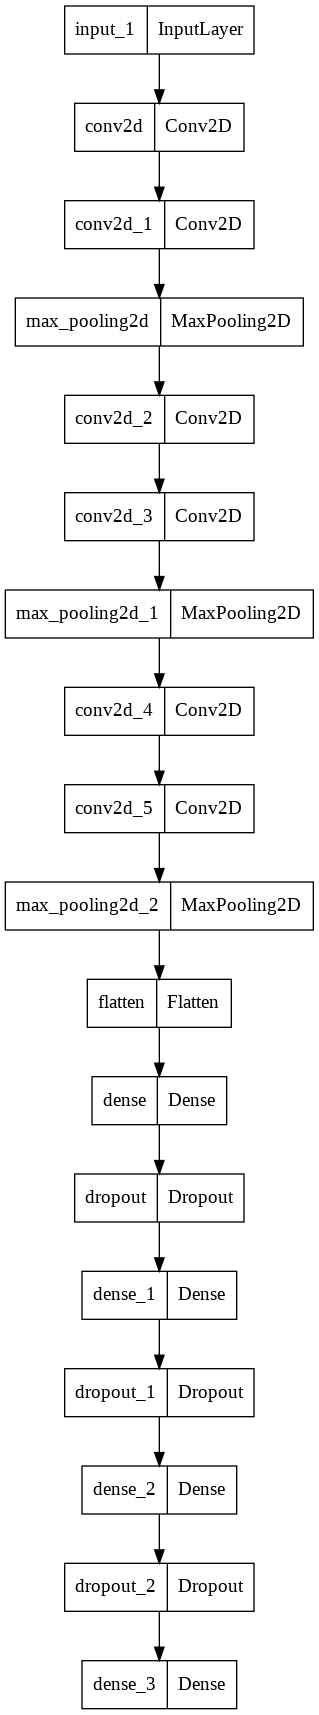

In [9]:
# Building the Convolutonal Nueral Network Model 6 from Model 1.2.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function =   MSE
model_6_version_2 = Model(inputs=input, outputs = output)
model_6_version_2.compile(optimizer='RMSprop', 
              loss='MSE',
              metrics=['acc'])

model_6_version_2.summary()
plot_model(model_6_version_2)

In [10]:
history_6_version_2 = model_6_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
8192/8192 [==============================] - 380s 45ms/step - loss: 0.1038 - acc: 0.8585 - val_loss: 0.1209 - val_acc: 0.8312
Epoch 2/10
8192/8192 [==============================] - 371s 45ms/step - loss: 0.0676 - acc: 0.9133 - val_loss: 0.1272 - val_acc: 0.8289
Epoch 3/10
8192/8192 [==============================] - 385s 47ms/step - loss: 0.0674 - acc: 0.9157 - val_loss: 0.2366 - val_acc: 0.6904
Epoch 4/10
8192/8192 [==============================] - 366s 45ms/step - loss: 0.1510 - acc: 0.8226 - val_loss: 0.4996 - val_acc: 0.5005
Epoch 5/10
8192/8192 [==============================] - 364s 44ms/step - loss: 0.4999 - acc: 0.5001 - val_loss: 0.4995 - val_acc: 0.5005
Epoch 6/10
8192/8192 [==============================] - 364s 44ms/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.4995 - val_acc: 0.5005
Epoch 7/10
8192/8192 [==============================] - 364s 44ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4995 - val_acc: 0.5005
Epoch 8/10
8192/8192 [===================

In [11]:
import joblib

In [13]:
joblib.dump(model_6_version_2, 'model_6_version_2')

INFO:tensorflow:Assets written to: ram://1c6d9291-cc14-4c7f-867a-9150c48f82fa/assets


INFO:tensorflow:Assets written to: ram://1c6d9291-cc14-4c7f-867a-9150c48f82fa/assets


['model_6_version_2']

In [14]:
model_6_version_2_object = joblib.load('model_6_version_2')

In [15]:
print("Test dataset accuracy for model 6 version 2 is: {0:.4f}".format(model_6_version_2_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 12s 44ms/step - loss: 0.4998 - acc: 0.5002
Test dataset accuracy for model 6 version 2 is: 0.5002
